# Thyroid clustering and predicting

At the start of this year, I have been diagnosed with type-1 hyperthyroidism. The result indicated that I have been at risk of thyroid for a longer time than intended, and current results shows Currently, this does pose a risk that it will worsen to thyroid cancer, but as of this writing (2024-04-28), this is not too big of an issue (yet).

Albeit the diagnosis came out benign, it has impacted my life a lot. My diet needs changes, certain things I like to eat is now limited or no longer allowed.

As the disruption in lifestyle are noticeable, and the risk of cancer are possible, if hyperthyroidism/hypothyroidism patients are notified at an earlier date, this could greatly help people adjust their lifestyle and help save a lot of money over the long run.

Therefore, the goal for my research over this topic will be:
- **Find out cluster characteristics**: Inspect and evaluate the data source to find out which characteristics help detect thyroid disorder.
- **Clustering Individuals**: After finding relations between presented values in the dataset, I will use them to group patients and people without hyper/hypothyroidism whether they are of a group that can catch this disorder later on, or not 
- **Associate Disorder or Not**: From the dataset, we will then predict whether the person is in risk of thyroid disorder or not. We will also compare it with the diagnosed result to see whether it convey any meanings.

## Approach
The research will be presented as follows:
1. EDA, Data Cleaning and Data Visualization
2. Build and Train a Model from the Data
3. Comparing the results with supervised training
4. Final Summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, average_precision_score, balanced_accuracy_score, precision_score

from sklearn.ensemble import RandomForestClassifier



In [2]:
data = pd.read_csv("thyroidDF.csv")
orig_data = pd.read_csv("thyroidDF.csv")

# 1. Exploratory Data Analysis

In this step, we will inspect and clean the original dataset, to remove unnecessary columns and infos, improving clustering performance.

In [3]:
display(data.info())
# Total number of missing values in each column
for column in data.columns:
    if data[column].isna().sum() > 0:
        print(f"Column {column} has {data[column].isna().sum()} values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

None

Column sex has 307 values
Column TSH has 842 values
Column T3 has 2604 values
Column TT4 has 442 values
Column T4U has 809 values
Column FTI has 802 values
Column TBG has 8823 values


In [4]:
print('TSH_measured', data['TSH_measured'].unique())
print('T3_measured', data['T3_measured'].unique())
print('TT4_measured', data['TT4_measured'].unique())
print('T4U_measured', data['T4U_measured'].unique())
print('FTI_measured', data['FTI_measured'].unique())
print('TBG_measured', data['TBG_measured'].unique())
print('TSH when TSH_measured f', data['TSH'][data['TSH_measured'] == 'f'].unique())
print('T3 when T3_measured f', data['T3'][data['T3_measured'] == 'f'].unique())
print('TT4 when TT4_measured f', data['TT4'][data['TT4_measured'] == 'f'].unique())
print('T4U when T4U_measured f', data['T4U'][data['T4U_measured'] == 'f'].unique())
print('FTI when FTI_measured f', data['FTI'][data['FTI_measured'] == 'f'].unique())
print('TBG when TBG_measured f', data['TBG'][data['TBG_measured'] == 'f'].unique())
print('target: ', data['target'].unique())
print('age: ', data['age'].unique())
for i in data.columns:
    if data[i].dtype == 'object':
        print(f'Unique values in {i}: {data[i].unique()}')

TSH_measured ['t' 'f']
T3_measured ['f' 't']
TT4_measured ['f' 't']
T4U_measured ['f' 't']
FTI_measured ['f' 't']
TBG_measured ['f' 't']
TSH when TSH_measured f [nan]
T3 when T3_measured f [nan]
TT4 when TT4_measured f [nan]
T4U when T4U_measured f [nan]
FTI when FTI_measured f [nan]
TBG when TBG_measured f [nan]
target:  ['-' 'S' 'F' 'AK' 'R' 'I' 'M' 'N' 'G' 'K' 'A' 'KJ' 'L' 'MK' 'Q' 'J' 'C|I'
 'O' 'LJ' 'H|K' 'D' 'GK' 'MI' 'P' 'FK' 'B' 'GI' 'C' 'GKJ' 'OI' 'D|R' 'E']
age:  [   29    41    36    32    60    77    28    54    42    51    37    16
    43    63    40    75    56    85    71    67    55    61    46    44
    82    64    70    33    59    53    52    49    35    48    27    69
    76    73    68    66    30    88    38    58    21    45    83    62
    25    86    72    14    15    39    26    20    80    90    23    18
    13    78    24    81    92    57    74     9    47    17    11    50
    34     8    79    31    65    84    12    10    19    22     1     2
    97     

## Feature Engineering

As can be seen from the dataset, and the dataset description, the following columns are related to one another: If one is true, then the other has value and vice versa:
- `TSH_measured` and `TSH`
- `T3_measured` and `T3`
- `TT4_measured` and `TT4`
- `T4U_measured` and `T4U`
- `FTI_measured` and `FTI`
- `TBG_measured` and `TBG`

Therefore, we can remove the `*_measured` columns, and fill its related `*` column with 0 as an assumption.


Additionally, from basic inspection of the dataset, we have additional columns that need processing:
- `patient_id` don't carry meaningful values to the checking, therefore we can drop this column
- `sex` has none value. For easier text processing, literal `None` object will be converted to `N`, following the convention of the dataset of F for female and M for male
- `target` has a lot of values that is explained by the dataset provider as below.
- `hypopituitary` only has `f` as its value. We can safely drop the column as well.
- `age` has certain value that are unreasonable. All of those values are larger than 100 so we will remove such rows.

```
    The diagnosis consists of a string of letters indicating diagnosed conditions.
    A diagnosis "-" indicates no condition requiring comment.  A diagnosis of the
    form "X|Y" is interpreted as "consistent with X, but more likely Y".  The
    conditions are divided into groups where each group corresponds to a class of
    comments.

    Letter  Diagnosis
    ------  ---------

    hyperthyroid conditions:

    A   hyperthyroid
    B   T3 toxic
    C   toxic goitre
    D   secondary toxic

    hypothyroid conditions:

    E   hypothyroid
    F   primary hypothyroid
    G   compensated hypothyroid
    H   secondary hypothyroid

    binding protein:

    I   increased binding protein
    J   decreased binding protein

    general health:

    K   concurrent non-thyroidal illness

    replacement therapy:

    L   consistent with replacement therapy
    M   underreplaced
    N   overreplaced

    antithyroid treatment:

    O   antithyroid drugs
    P   I131 treatment
    Q   surgery

    miscellaneous:

    R   discordant assay results
    S   elevated TBG
    T   elevated thyroid hormones
```

In [5]:
display(data['target'].unique())

array(['-', 'S', 'F', 'AK', 'R', 'I', 'M', 'N', 'G', 'K', 'A', 'KJ', 'L',
       'MK', 'Q', 'J', 'C|I', 'O', 'LJ', 'H|K', 'D', 'GK', 'MI', 'P',
       'FK', 'B', 'GI', 'C', 'GKJ', 'OI', 'D|R', 'E'], dtype=object)

For simplicity, we can group all the possible targets into 4 groups:
- Diagnosed with hyperthyroidism
- Diagnosed with hypothyroidism
- Confirmed negative to thyroid disorder
- Unsure
  - All those not part of the three groups above and be categorized as None.

Those with targets like `A|B`, we will be using the latter first for categorization

For the `*_measured` columns and its corresponding numeric value, we will use `fillna(0)` to remove null values.

In [6]:
# List of columns that will be dropped
print(data.columns)
col_to_drop = ['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id']
data.drop(col_to_drop, axis = 1, inplace = True)

col_with_null = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in col_with_null:
    data[col] = data[col].fillna(0)

# Categorize targets into groups
target_hyperthyroid = [
    'A', # hyperthyroid
    'B', # T3 toxic
    'C', # toxic goitre
    'D', # secondary toxic
    'O', # My current treatment, antithyroid drugs
    'P', # I131 treatment
    'Q', # surgery
    'S', # elevated TBG
    'T', # My current diagnosis alongside hyperthyroidism, elevated thyroid hormones
]
target_hypothyroid = ['E', 'F', 'G', 'H']
negative_thyroid_disorder = '-'

def categorize_targets(value):
    diagnoses = reversed(value.split("|")) if 'I' in value else list(value)
    for category in diagnoses:
        if category in target_hyperthyroid:
            return 'Hyperthyroidism'
    for category in diagnoses:
        if category in target_hypothyroid:
            return 'Hypothyroidism'
    for category in diagnoses:
        if category == negative_thyroid_disorder:
            return 'Negative'
    
data['target'] = data['target'].apply(categorize_targets)
data['sex'] = data['sex'].fillna('N')
data['sex']
data.drop('hypopituitary', axis=1, inplace=True)
data = data[data['age'] < 100]

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')


In [7]:
data.isna().sum()

age                       0
sex                       0
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
psych                     0
TSH                       0
T3                        0
TT4                       0
T4U                       0
FTI                       0
TBG                       0
referral_source           0
target                 1385
dtype: int64

As unknown targets can be re-diagnosed, we will be splitting them and use them as part of the test data later

In [8]:
na_target = data[data['target'].isna()]
na_target.info()
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1385 entries, 32 to 9169
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1385 non-null   int64  
 1   sex                  1385 non-null   object 
 2   on_thyroxine         1385 non-null   object 
 3   query_on_thyroxine   1385 non-null   object 
 4   on_antithyroid_meds  1385 non-null   object 
 5   sick                 1385 non-null   object 
 6   pregnant             1385 non-null   object 
 7   thyroid_surgery      1385 non-null   object 
 8   I131_treatment       1385 non-null   object 
 9   query_hypothyroid    1385 non-null   object 
 10  query_hyperthyroid   1385 non-null   object 
 11  lithium              1385 non-null   object 
 12  goitre               1385 non-null   object 
 13  tumor                1385 non-null   object 
 14  psych                1385 non-null   object 
 15  TSH                  1385 non-null   float

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7783 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7783 non-null   int64  
 1   sex                  7783 non-null   object 
 2   on_thyroxine         7783 non-null   object 
 3   query_on_thyroxine   7783 non-null   object 
 4   on_antithyroid_meds  7783 non-null   object 
 5   sick                 7783 non-null   object 
 6   pregnant             7783 non-null   object 
 7   thyroid_surgery      7783 non-null   object 
 8   I131_treatment       7783 non-null   object 
 9   query_hypothyroid    7783 non-null   object 
 10  query_hyperthyroid   7783 non-null   object 
 11  lithium              7783 non-null   object 
 12  goitre               7783 non-null   object 
 13  tumor                7783 non-null   object 
 14  psych                7783 non-null   object 
 15  TSH                  7783 non-null   float6

Reaching this step, the data has now been pre-processed to have no None/null/NaN values, we will be using this data for the steps afterward

In [10]:
df = data.copy()

In [11]:
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target
0,29,F,f,f,f,f,f,f,f,t,...,f,f,0.3,0.0,0.0,0.00,0.0,0.0,other,Negative
1,29,F,f,f,f,f,f,f,f,f,...,f,f,1.6,1.9,128.0,0.00,0.0,0.0,other,Negative
2,41,F,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,0.0,0.00,0.0,11.0,other,Negative
3,36,F,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,0.0,0.00,0.0,26.0,other,Negative
4,32,F,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,0.0,0.00,0.0,36.0,other,Hyperthyroidism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,70,F,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,88.0,0.74,119.0,0.0,SVI,Negative
9167,56,M,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,64.0,0.83,77.0,0.0,SVI,Negative
9168,22,M,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,91.0,0.92,99.0,0.0,SVI,Negative
9170,47,F,f,f,f,f,f,f,f,f,...,f,f,0.0,0.0,75.0,0.85,88.0,0.0,other,Negative


## Data Encoding

All the `f`, `t` columns can be converted to 0-1 instead. So is the `sex` column, we can convert it to `[0, 1, 2]` instead of `[F, M, N]`

In [12]:
df['sex'] = df['sex'].map({'F': 0, 'M': 1, 'N': 2})
na_target['sex'] = na_target['sex'].map({'F': 0, 'M': 1, 'N': 2})

for column in ['on_thyroxine','query_on_thyroxine','on_antithyroid_meds','sick','pregnant','thyroid_surgery','I131_treatment','query_hypothyroid','query_hyperthyroid','lithium','goitre','tumor','psych']:
    df[column] = df[column].map({ 'f': 0, 't': 1})
    na_target[column] = na_target[column].map({'f': 0, 't': 1})
df['referral_source'] = LabelEncoder().fit_transform(df['referral_source'])
na_target['referral_source'] = LabelEncoder().fit_transform(na_target['referral_source'])


/tmp/ipykernel_97080/2879512045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_target['sex'] = na_target['sex'].map({'F': 0, 'M': 1, 'N': 2})
/tmp/ipykernel_97080/2879512045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_target[column] = na_target[column].map({'f': 0, 't': 1})
/tmp/ipykernel_97080/2879512045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Data Visualizing

In this section, I will be looking at the `TSH`, `TT4`, `T3`, `T4U`, `gender`, `FTI`, `TBG` columns, and its relations to the `target` column.

Aside from the `gender` column, the other aforementioned variables are usually checked for diagnosis purposes. Therefore, having a look at such info will give us some insights on how to cluster and predict datasets from here.

### Thyroid disorder distribution

,target,count
0,Negative,6767
1,Hypothyroidism,657
2,Hyperthyroidism,359


[Text(0.5, 1.0, 'Target Distribution (Unspecified Excluded)')]

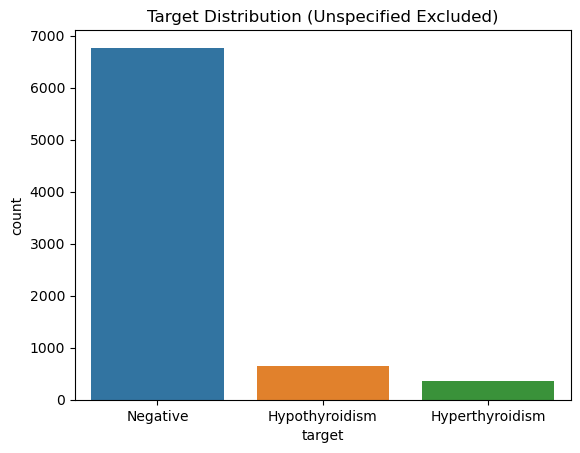

In [13]:
target_df = df['target'].value_counts().reset_index()

display(target_df)

plot = sns.barplot(target_df, x = 'target', y = 'count', hue='target')
plot.set(title = "Target Distribution (Unspecified Excluded)")

/tmp/ipykernel_97080/1486233378.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(['Female', 'Male', 'Other'])


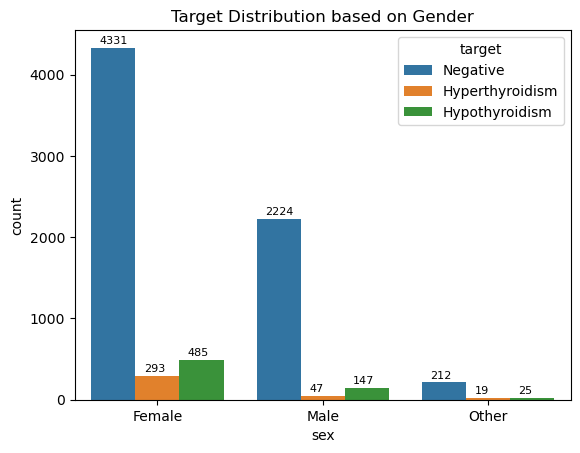

In [14]:
plot = sns.countplot(df, x = 'sex', hue='target')
plot.set_xticklabels(['Female', 'Male', 'Other'])
plot.set_title("Target Distribution based on Gender")
for p in plot.patches:
    if int(p.get_height()) == 0:
        continue
    plot.annotate(
        int(p.get_height()), xy=(p.get_x() + 0.05, p.get_height() + 50), fontsize=8
    )

From the count plot, we can see that on a percentage level, females are more likely to be positive to one of the disorders, about 10% more than males. Those with non-binary genders are also statistically likely, but due to low sample size, we cannot really say whether they are more likely to be affected by the disorder or not.

### Target Distribution based on TSH level

For this part. We will be ignoring most of those without (pre-transformed) numerical `*` values. This will be showcased through viewing original dataset.

In [15]:
negative_noTSH_df = orig_data[(orig_data['target'] == negative_thyroid_disorder)]
negative_noTSH_df = negative_noTSH_df[negative_noTSH_df['TSH_measured'] != 'f']
negative_noTSH_df['TSH'].describe()

count    6082.00000
mean        1.69436
std         2.88035
min         0.00500
25%         0.52000
50%         1.30000
75%         2.20000
max       136.00000
Name: TSH, dtype: float64

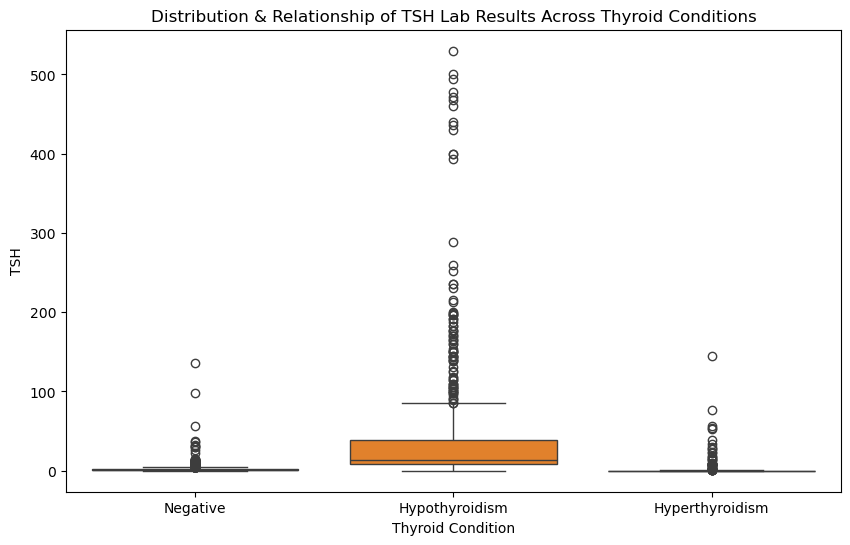

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
Hyperthyroidism,240.0,3.417958,13.136100,0.005,0.03,0.075,0.25,145.0
Hypothyroidism,656.0,42.216616,74.777120,0.100,8.20,13.850,39.00,530.0
Negative,6078.0,1.694979,2.881159,0.005,0.52,1.300,2.20,136.0


In [16]:
tsh_df = df[df['TSH'] > 0]
plt.figure(figsize = (10,6))
sns.boxplot(tsh_df, x='target', y='TSH', hue = 'target', )
plt.title('Distribution & Relationship of TSH Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('TSH')
plt.show()
tsh_df.groupby('target')['TSH'].describe()

As can be seen from the figure above. We cannot really see the statistical differences between those with Hyperthyroidism and Negative just by looking at TSH level. Hypothyroidism detection, however, is significant.

After filtering away 0-level TSH (set by us), Looking at the describe table above, we can see a pattern that Hyperthyroidism patients have much lower TSH level even at the 75% percentile.
This is also noted by [1](https://www.medicalnewstoday.com/articles/326774), that hyperthyroidism have lower than average TSH level.

Hyperthyroidism dataset's mean value were unwantedly skewed by a few outliers with much higher than expected TSH level, and not enough input to skew the mean back to correct value, despite its 75% percentile to still be lower than the negative's and Hypothyroidism's cases.

### Target distribution based on T3 level

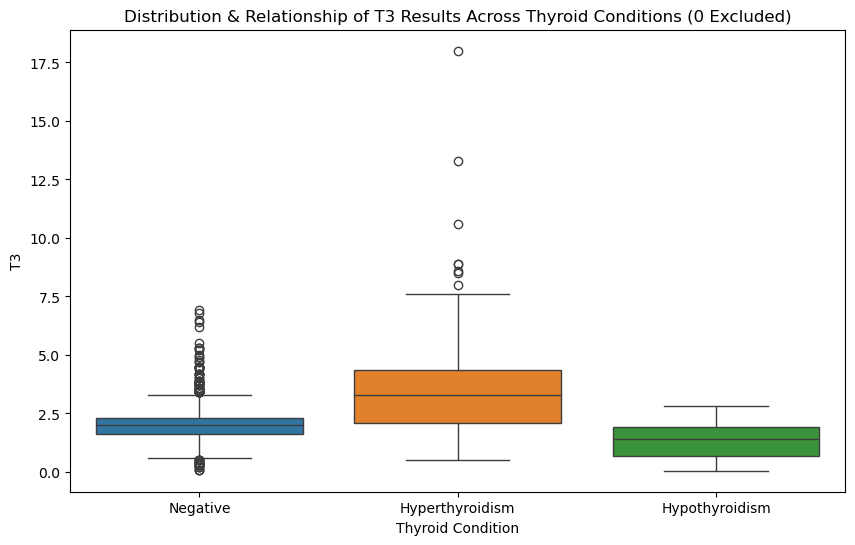

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
Hyperthyroidism,238.0,3.647479,2.133650,0.50,2.1,3.3,4.375,18.0
Hypothyroidism,493.0,1.361055,0.686576,0.05,0.7,1.4,1.900,2.8
Negative,4759.0,1.989626,0.561791,0.10,1.6,2.0,2.300,6.9


In [17]:
t3_df = df[df['T3'] > 0]
plt.figure(figsize = (10,6))
sns.boxplot(t3_df, x='target', y='T3', hue = 'target', )
plt.title('Distribution & Relationship of T3 Results Across Thyroid Conditions (0 Excluded)')
plt.xlabel('Thyroid Condition')
plt.ylabel('T3')
plt.show()
t3_df.groupby('target')['T3'].describe()

For the dataset, we can see that hyperthyroidism patients have much higher max T3 level than the other 2 targets, signifying this is one of the important distinction of hyperthyroidism: extremely high T3 values. However, due to lack of data for the disorder, we cannot say much more than it having high maximum/75% percentile value.

Some supporting data is the fact that maximum value of `negative` targets are not as high. Even its 75% percentile value and its outliers are still lower than Hyperthyroidism's whiskers, suggesting that the range for Hyperthyroidism patients are much higher, and when we out of that (around 7) level, it is likely that one can be diagnosed with Hyperthyroidism.

### Target distribution based on TT4 level

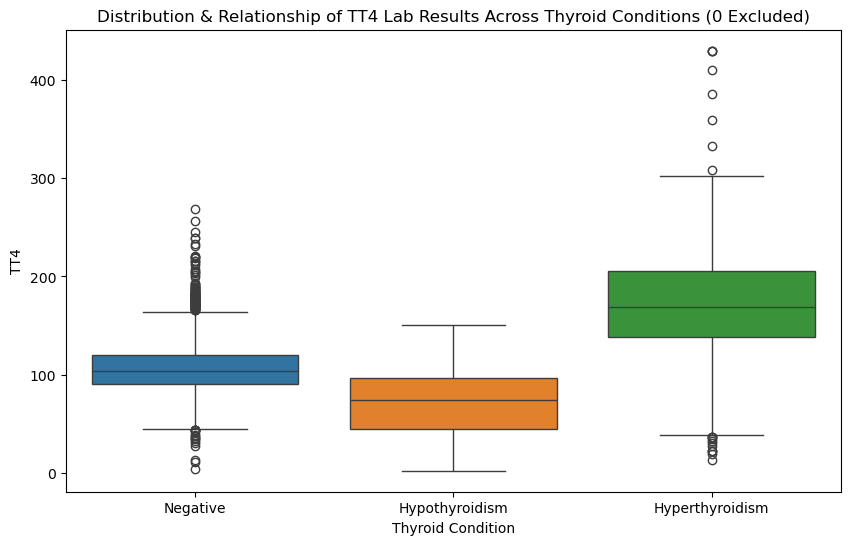

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
Hyperthyroidism,274.0,171.142336,71.164553,13.0,138.25,168.5,205.75,430.0
Hypothyroidism,648.0,70.164599,36.202067,2.0,44.75,74.0,96.00,150.0
Negative,6422.0,105.950171,24.696753,4.0,90.00,104.0,120.00,269.0


In [18]:
tt4_df = df[df['TT4'] > 0]
plt.figure(figsize = (10,6))
sns.boxplot(tt4_df, x='target', y='TT4', hue = 'target', )
plt.title('Distribution & Relationship of TT4 Lab Results Across Thyroid Conditions (0 Excluded)')
plt.xlabel('Thyroid Condition')
plt.ylabel('TT4')
plt.show()
tt4_df.groupby('target')['TT4'].describe()

There are a lot of overlaps when one is diagnosed Hypothyroidism or Negative. Hyperthyroidism, however, consistently shows much larger TT4 value than intended.

### Target distribution based on T4U level

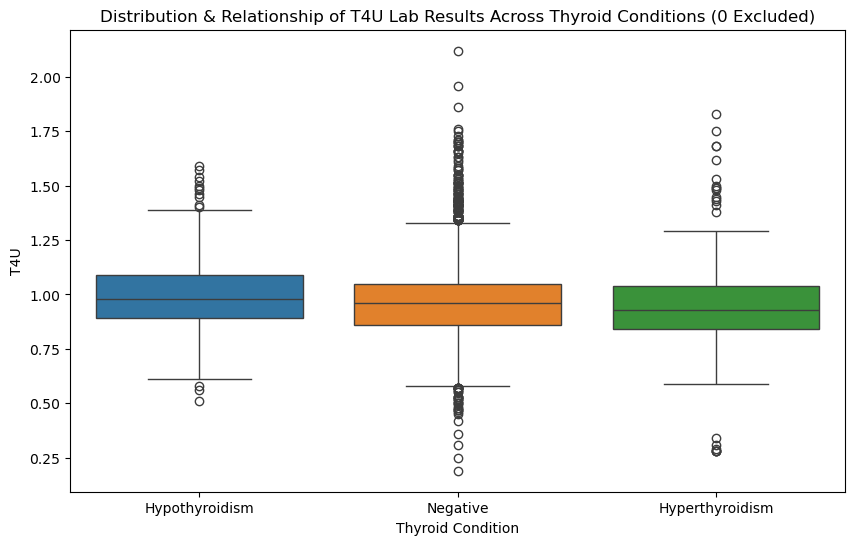

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
Hyperthyroidism,265.0,0.954038,0.223413,0.28,0.84,0.93,1.04,1.83
Hypothyroidism,610.0,0.996459,0.168016,0.51,0.89,0.98,1.09,1.59
Negative,6141.0,0.964565,0.159996,0.19,0.86,0.96,1.05,2.12


In [19]:
T4U_df = df[df['T4U'] > 0]
plt.figure(figsize = (10,6))
sns.boxplot(T4U_df, x='target', y='T4U', hue = 'target', )
plt.title('Distribution & Relationship of T4U Lab Results Across Thyroid Conditions (0 Excluded)')
plt.xlabel('Thyroid Condition')
plt.ylabel('T4U')
plt.show()
T4U_df.groupby('target')['T4U'].describe()

The results are mixed, suggesting that this cannot reliably be used as a most-important feature.

### Target distribution based on FTI level

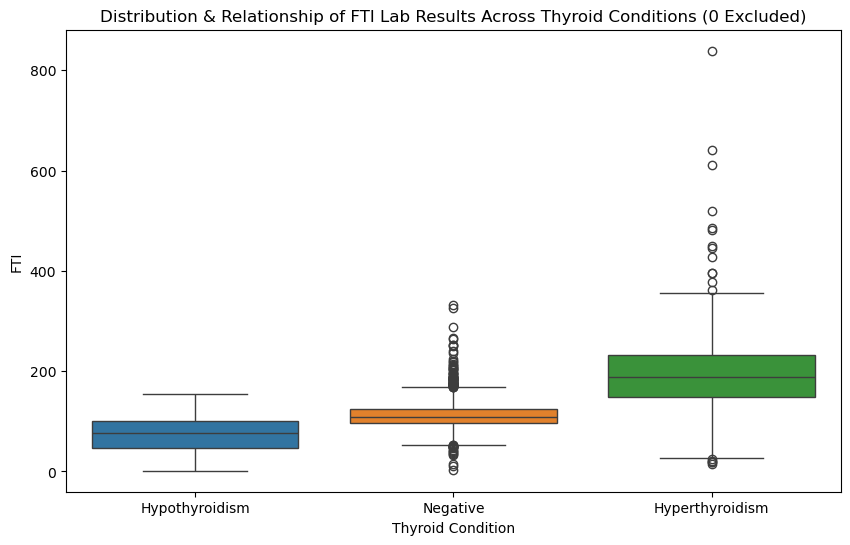

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
Hyperthyroidism,265.0,194.656604,102.700428,14.0,149.0,188.0,232.0,839.0
Hypothyroidism,611.0,71.910622,37.251486,1.4,46.0,77.0,100.0,155.0
Negative,6147.0,110.936148,23.460071,3.5,96.0,109.0,125.0,332.0


In [20]:
FTI_df = df[df['FTI'] > 0]
plt.figure(figsize = (10,6))
sns.boxplot(FTI_df, x='target', y='FTI', hue = 'target', )
plt.title('Distribution & Relationship of FTI Lab Results Across Thyroid Conditions (0 Excluded)')
plt.xlabel('Thyroid Condition')
plt.ylabel('FTI')
plt.show()
FTI_df.groupby('target')['FTI'].describe()

We can see that, Hyperthyroidism-diagnosed patients have much higher FTI value. This is also described in <sup>[2](https://www.thyroid.org/thyroid-function-tests/)</sup>, where it is said that low TSH and high FTI value is found in people with hyperthyroidism

### Target distribution based on TBG level

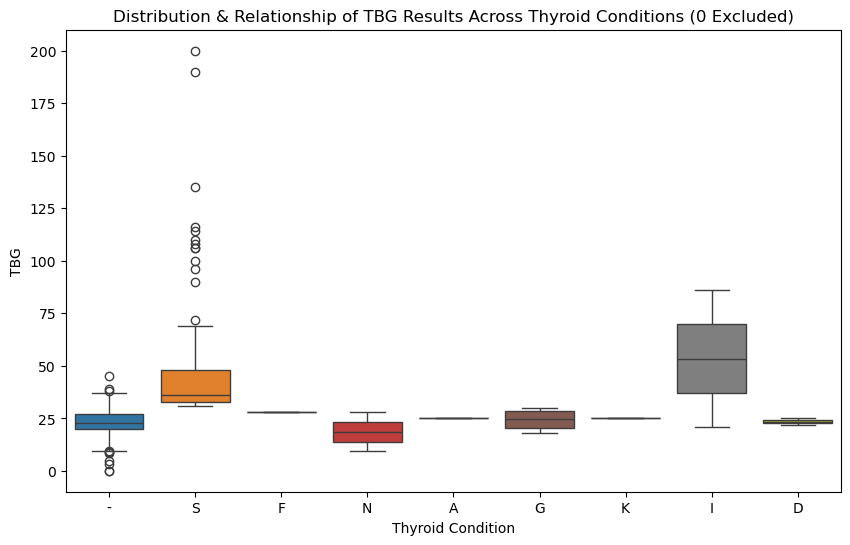

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
-,251.0,22.901793,6.139961,0.100000,20.000000,23.000000,27.000,45.0
A,1.0,25.000000,NaN,25.000000,25.000000,25.000000,25.000,25.0
D,2.0,23.500000,2.121320,22.000000,22.750000,23.500000,24.250,25.0
F,1.0,28.000000,NaN,28.000000,28.000000,28.000000,28.000,28.0
G,4.0,24.250000,5.678908,18.000000,20.250000,24.500000,28.500,30.0
I,2.0,53.500000,45.961941,21.000000,37.250000,53.500000,69.750,86.0
K,1.0,25.000000,NaN,25.000000,25.000000,25.000000,25.000,25.0
N,2.0,18.649999,13.222898,9.299999,13.974999,18.649999,23.325,28.0
S,85.0,50.705882,33.115535,31.000000,33.000000,36.000000,48.000,200.0


In [21]:
TBG_df = orig_data[orig_data['TBG_measured'] != 'f'].copy()
TBG_df['TBG'] = TBG_df['TBG'].fillna(0)
plt.figure(figsize = (10,6))
sns.boxplot(TBG_df, x='target', y='TBG', hue = 'target', )
plt.title('Distribution & Relationship of TBG Results Across Thyroid Conditions (0 Excluded)')
plt.xlabel('Thyroid Condition')
plt.ylabel('TBG')
plt.show()
TBG_df.groupby('target')['TBG'].describe()

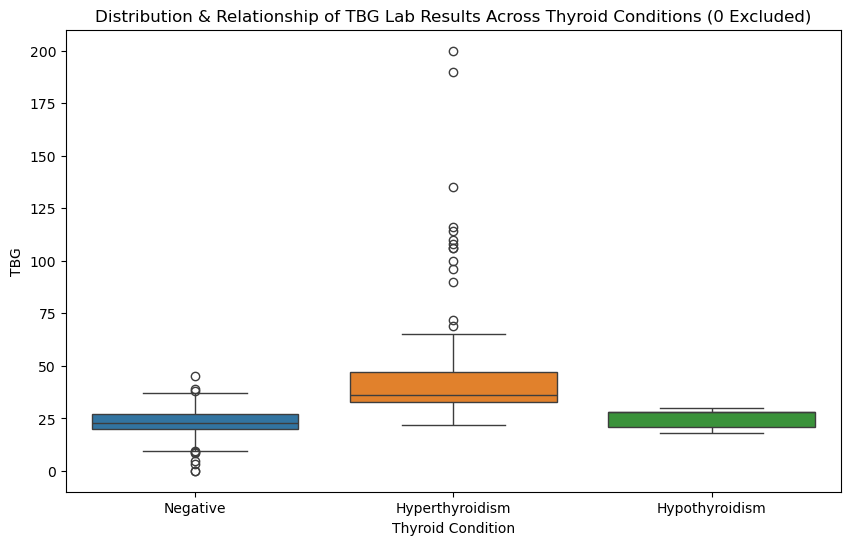

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
Hyperthyroidism,88.0,49.795455,32.903607,22.0,33.0,36.0,47.25,200.0
Hypothyroidism,5.0,25.000000,5.196152,18.0,21.0,28.0,28.00,30.0
Negative,251.0,22.901793,6.139961,0.1,20.0,23.0,27.00,45.0


In [22]:
TBG_df = df[df['TBG'] > 0]
plt.figure(figsize = (10,6))
sns.boxplot(TBG_df, x='target', y='TBG', hue = 'target', )
plt.title('Distribution & Relationship of TBG Lab Results Across Thyroid Conditions (0 Excluded)')
plt.xlabel('Thyroid Condition')
plt.ylabel('TBG')
plt.show()
TBG_df.groupby('target')['TBG'].describe()

By viewing TBG with original data and the cleaned data one. We can see that hyperthyroidism patients have significantly higher TBG value than the other two diagnosis categories.

The original given TBG data contains mostly NaN. So this result should not be a meaningful one, since it has too much noise compared to actual data to use for prediction.

### Target distribution on age

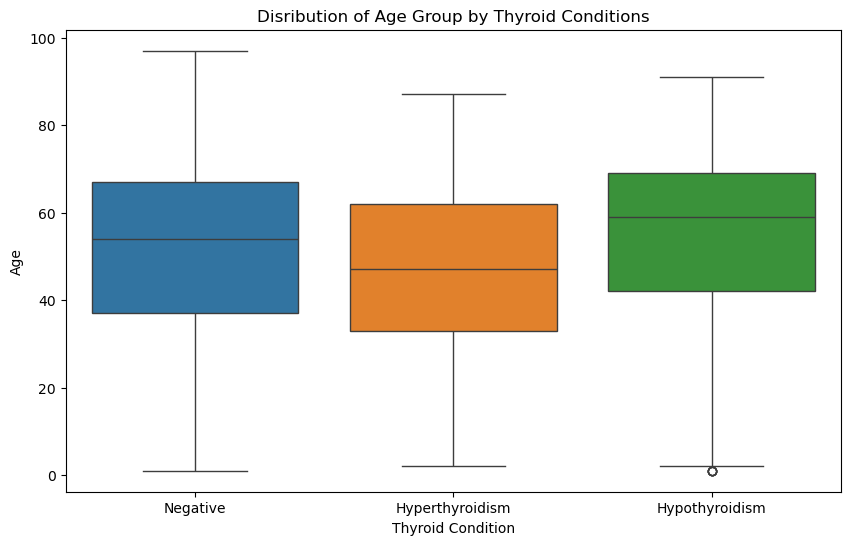

In [23]:
plt.figure(figsize = (10,6))
sns.boxplot(df, x='target', y='age', hue = 'target', )
plt.title('Disribution of Age Group by Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('Age')
plt.show()

There is a lot of overlaps for all the age groups, signifying this may not be as relevant a feature as the `T*` and `F*` levels previously described

## Target Distribution based other features


/tmp/ipykernel_97080/3829992525.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["False", "True"])
/tmp/ipykernel_97080/3829992525.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["False", "True"])
/tmp/ipykernel_97080/3829992525.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["False", "True"])
/tmp/ipykernel_97080/3829992525.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["False", "True"])
/tmp/ipykernel_97080/3829992525.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_x

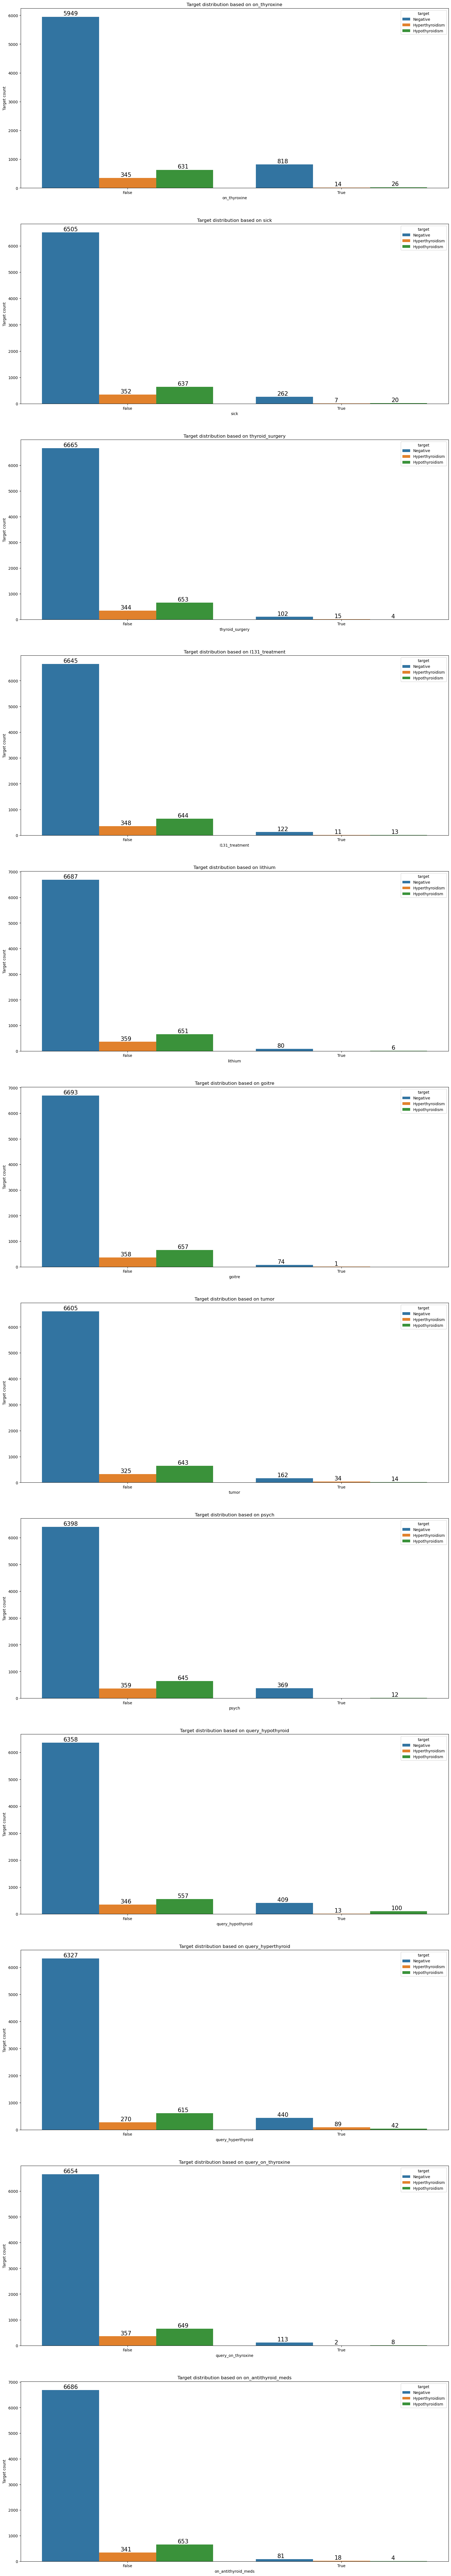

In [24]:

features = ['on_thyroxine', 'sick', 'thyroid_surgery', 'I131_treatment', 'lithium', 'goitre', 'tumor', 'psych', 'query_hypothyroid', 'query_hyperthyroid', 'query_on_thyroxine', 'on_antithyroid_meds'] 

fig, axes = plt.subplots(nrows = len(features), ncols = 1, figsize = (20, 10 * len(features)))
for i in range(len(features)):
    ax = sns.countplot(df, x = features[i], hue = 'target', ax = axes[i])
    ax.set_xticklabels(["False", "True"])
    ax.set_xlabel(features[i])
    ax.set_ylabel("Target count")
    ax.set_title(f"Target distribution based on {features[i]}")
    for p in ax.patches:
        if (int(p.get_height()) == 0):
            continue;
        ax.annotate(int(p.get_height()), xy=(p.get_x() + 0.1, p.get_height() + 50), fontsize=15)

fig.show()

### Other features summary
As can be seen, almost all of the positive cases are aligned with the `False` side, indicating that these variables aren't as closely related to diagnoses as compared to the `T*` and `FTI` values.

In [25]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG',
       'referral_source', 'target'],
      dtype='object')

## Copy data for usage


In [26]:
final_df = df.copy(deep = True)
# final_df.drop(['on_thyroxine', 'query_on_thyroxine','on_antithyroid_meds', 'sick', 'thyroid_surgery', 'I131_treatment', 'lithium', 'goitre', 'tumor', 'psych'], axis = 1, inplace=True)

scaled_final_df = final_df.copy(deep = True)
scaled_final_df['TSH'] = StandardScaler().fit_transform(final_df[['TSH']])
scaled_final_df['TT4'] = StandardScaler().fit_transform(final_df[['TT4']])
scaled_final_df['T3'] = StandardScaler().fit_transform(final_df[['T3']])
scaled_final_df['T4U'] = StandardScaler().fit_transform(final_df[['T4U']])
scaled_final_df['FTI'] = StandardScaler().fit_transform(final_df[['FTI']])
scaled_final_df['TBG'] = StandardScaler().fit_transform(final_df[['TBG']])
final_df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target
0,29,0,0,0,0,0,0,0,0,1,...,0,0,0.3,0.0,0.0,0.0,0.0,0.0,5,Negative
1,29,0,0,0,0,0,0,0,0,0,...,0,0,1.6,1.9,128.0,0.0,0.0,0.0,5,Negative
2,41,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,11.0,5,Negative
3,36,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,26.0,5,Negative
4,32,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,36.0,5,Hyperthyroidism


## Data Visualization Summary
From the visualization, we have the following that can be seen:
- The following show some indications to Hyperthyroidism: Very low TSH level, Very High T3 level, High TT4 level, High FTI Level, Very High TBG Level 
- The following show some indications to Hypothyroidism: Very high TSH level, Low FTI Level


# 2. Data Modelling

## Data split 

In [27]:
x = final_df.drop('target', axis = 1)
y = final_df['target']
x_negative = final_df[final_df['target'] == 'Negative'].drop('target', axis = 1)
x_positive = final_df[final_df['target'] != 'Negative'].drop('target', axis = 1)
y_negative = final_df[final_df['target'] == 'Negative']['target']
y_positive = final_df[final_df['target'] != 'Negative']['target']
# display(x_positive, y_positive)
x

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source
0,29,0,0,0,0,0,0,0,0,1,...,0,0,0,0.3,0.0,0.0,0.00,0.0,0.0,5
1,29,0,0,0,0,0,0,0,0,0,...,0,0,0,1.6,1.9,128.0,0.00,0.0,0.0,5
2,41,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.00,0.0,11.0,5
3,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.00,0.0,26.0,5
4,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.00,0.0,36.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,70,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,88.0,0.74,119.0,0.0,3
9167,56,1,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,64.0,0.83,77.0,0.0,3
9168,22,1,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,91.0,0.92,99.0,0.0,3
9170,47,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,75.0,0.85,88.0,0.0,5


In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

x_positive_train, x_positive_test, y_positive_train, y_positive_test = train_test_split(x_positive, y_positive, test_size=0.2, random_state=42)

In [29]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6226, 22)
(1557, 22)
(6226,)
(1557,)


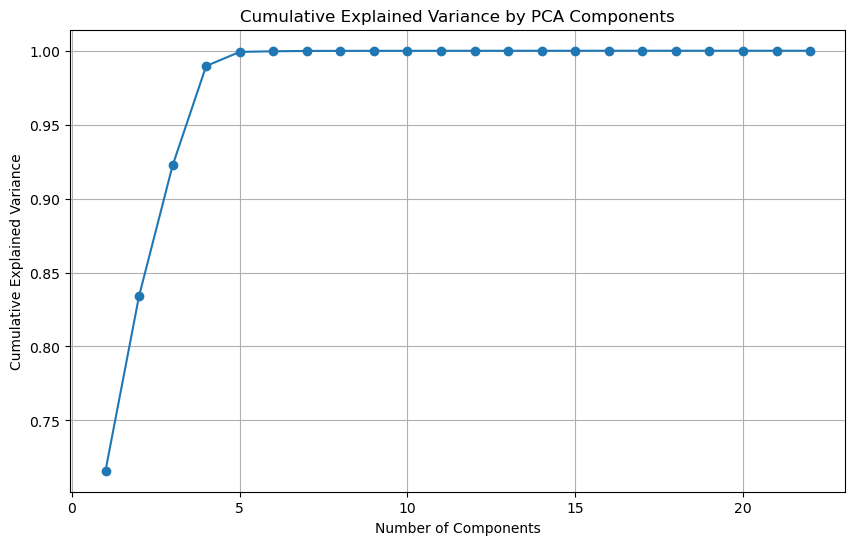

In [30]:
pca_full = PCA().fit(x_train)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_.cumsum(), marker = 'o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

As we can see, even with just 1 principal components, the cumsum already reached around 0.7. If we use n_components = 5 or more, it scaled to close or at 1.0. So 1, 2, or 3 will be reasonable as n_components

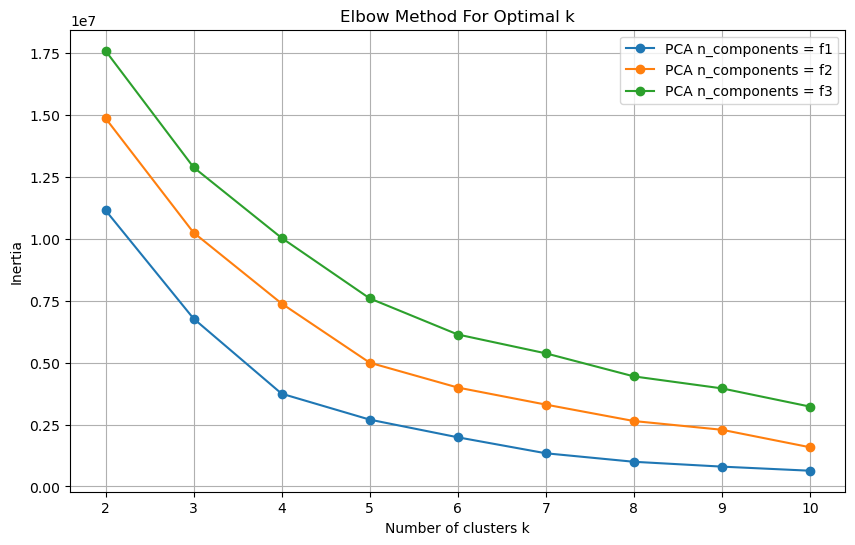

In [31]:
plt.figure(figsize=(10, 6))

for i in range(1, 4):
    pca = PCA(n_components = i, random_state=42)
    x_pca = pca.fit_transform(x_train)
    K_mean_clusters = range(2, 11)
    inertia = []
    for n_clusters in K_mean_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(x_pca)
        inertia.append(kmeans.inertia_)
    plt.plot(K_mean_clusters, inertia, marker='o', label = f"PCA n_components = f{i}")

# pca = PCA(n_components = 1)
# x_pca = pca.fit_transform(x_train)
# K_mean_clusters = range(1, 11)
# inertia = []


plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.xticks(K_mean_clusters)
plt.grid(True)
plt.legend()
plt.show()

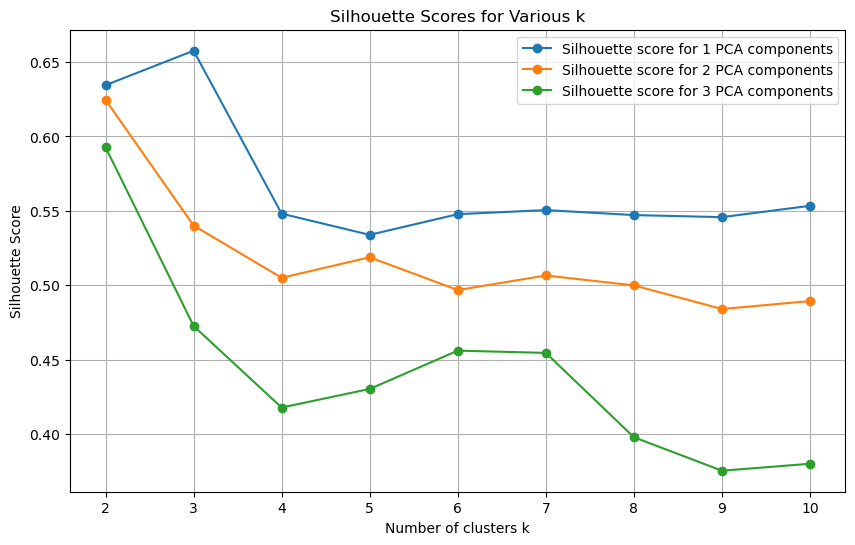

In [32]:


plt.figure(figsize=(10, 6))
for i in range(1, 4):
    pca = PCA(n_components = i, random_state=42)
    x_pca = pca.fit_transform(x_train)
    K_mean_clusters = range(2, 11)
    inertia = []
    silhouette_scores = []
    silhouette_clusters = range(2, 11)
    for k in silhouette_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x_pca)
        score = silhouette_score(x_pca, labels)
        silhouette_scores.append(score)
    plt.plot(silhouette_clusters, silhouette_scores, marker='o', label = f"Silhouette score for {i} PCA components")
plt.title('Silhouette Scores for Various k')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(silhouette_clusters)
plt.legend()
plt.grid(True)
plt.show()


From the 2 graphs, it is re-affirming that the optimal number of cluster is **3**, and the optional number of PCA components to use is **1**.
Considering that the silhouette score is high, PCA cumsum is over 0.9 even with just 1 feature. Therefore, we will use Kmeans = 3 for clustering

In [33]:
pca = PCA(n_components = 1, random_state=42)
x_pca = pca.fit_transform(x_train)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans = kmeans.fit(x_pca)
kmeans_labels = kmeans.predict(x_pca)
# x_train[f"KMeans_Cluster = {3}"] = kmeans_labels
kmeans_labels.size


6226

In [34]:
import itertools
display(type(y_train))
display(type(kmeans_labels))

# test_kmean_labels = kmeans.predict(x_test)
best_accuracy = -1
best_permutation = []
for permutation in itertools.permutations(range(3)):
    map_kv = {
        "Negative": permutation[0],
        "Hyperthyroidism": permutation[1],
        "Hypothyroidism": permutation[2],
    }
    y_train_labeled = y_train.map(map_kv)
    accuracy = accuracy_score(y_train_labeled, kmeans_labels)
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_permutation = permutation

y_train_kv = {'Negative': best_permutation[0], 'Hyperthyroidism': best_permutation[1], 'Hypothyroidism': best_permutation[2]}
y_train_vk = {v: k for k, v in y_train_kv.items()}
y_train_labeled = y_train.map(y_train_kv)
# display(y_train_labeled)

display(accuracy_score(y_train_labeled, kmeans_labels))

pandas.core.series.Series

numpy.ndarray

0.8303886925795053

In [35]:
tmp = x_train.copy()
tmp['KMeans_Cluster_Predicted'] = np.array([y_train_vk[v] for v in kmeans_labels])
tmp['actual'] = y_train
tmp

for target in ['Hypothyroidism', 'Hyperthyroidism', 'Negative']:
    dataset = tmp[tmp['actual'] == target]
    correct_dataset = tmp[(tmp['actual'] == target) & (tmp['KMeans_Cluster_Predicted'] == target)]
    print(f"Precision for {target}: {correct_dataset.shape[0] / dataset.shape[0]}")

display(tmp[tmp['actual'] == 'Negative'])
display(tmp[tmp['actual'] != tmp['KMeans_Cluster_Predicted']])

Precision for Hypothyroidism: 0.467680608365019
Precision for Hyperthyroidism: 0.5052264808362369
Precision for Negative: 0.8828745612414558


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,KMeans_Cluster_Predicted,actual
2456,63,0,0,0,0,0,0,0,0,0,...,0,2.80,2.0,93.0,1.04,89.0,0.0,1,Negative,Negative
3762,60,0,1,1,0,0,0,0,0,0,...,0,0.00,1.7,75.0,1.03,72.0,0.0,5,Negative,Negative
2563,60,1,0,0,0,0,0,0,0,0,...,0,0.00,0.0,0.0,0.00,0.0,19.0,5,Hypothyroidism,Negative
6266,39,1,0,0,0,0,0,0,0,0,...,1,1.10,1.8,91.0,0.94,97.0,0.0,1,Negative,Negative
741,23,1,0,0,0,0,0,0,0,0,...,0,0.60,2.1,105.0,1.05,100.0,0.0,5,Negative,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,61,0,0,0,0,0,0,0,0,0,...,0,0.20,2.3,112.0,1.01,111.0,0.0,5,Negative,Negative
2588,33,0,0,0,0,0,0,0,0,0,...,0,0.00,0.0,0.0,0.00,0.0,22.0,5,Hypothyroidism,Negative
2368,39,0,0,0,0,0,0,0,0,0,...,0,0.30,0.0,0.0,0.00,0.0,0.0,3,Hypothyroidism,Negative
5404,31,0,1,0,0,0,0,0,0,1,...,0,5.00,0.0,141.0,1.09,130.0,0.0,5,Negative,Negative


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,KMeans_Cluster_Predicted,actual
2563,60,1,0,0,0,0,0,0,0,0,...,0,0.000000,0.0,0.0,0.00,0.0,19.0,5,Hypothyroidism,Negative
394,51,0,0,0,0,0,0,0,0,0,...,0,5.500000,4.4,4.0,1.11,3.5,0.0,5,Hypothyroidism,Negative
8113,64,0,0,0,0,0,0,0,0,0,...,0,6.200000,2.0,73.0,1.00,73.0,0.0,5,Negative,Hypothyroidism
8792,33,0,0,0,0,0,0,0,0,1,...,0,0.000000,0.0,0.0,0.00,0.0,22.0,5,Hypothyroidism,Negative
3467,62,0,0,0,0,0,0,0,0,1,...,0,8.599999,0.0,86.0,0.84,101.0,0.0,5,Negative,Hypothyroidism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3057,73,0,0,0,0,0,0,0,0,0,...,0,1.200000,2.3,74.0,0.00,0.0,0.0,5,Hypothyroidism,Negative
7419,78,0,0,0,0,0,0,0,0,0,...,0,38.000000,1.4,74.0,0.98,76.0,0.0,1,Negative,Hypothyroidism
2635,78,0,0,0,0,0,0,0,0,0,...,0,0.050000,1.3,101.0,0.00,0.0,0.0,3,Hypothyroidism,Negative
2588,33,0,0,0,0,0,0,0,0,0,...,0,0.000000,0.0,0.0,0.00,0.0,22.0,5,Hypothyroidism,Negative


In [36]:
x_test_pca = pca.transform(x_test)
kmeans_labels_test = kmeans.predict(x_test_pca)

test_best_accuracy = -1
test_best_permutation = []
for permutation in itertools.permutations(range(3)):
    map_kv = {
        "Negative": permutation[0],
        "Hyperthyroidism": permutation[1],
        "Hypothyroidism": permutation[2],
    }
    y_test_labeled = y_test.map(map_kv)
    accuracy = accuracy_score(y_test_labeled, kmeans_labels_test)
    if test_best_accuracy < accuracy:
        test_best_accuracy = accuracy
        test_best_permutation = permutation

y_test_kv = {'Negative': test_best_permutation[0], 'Hyperthyroidism': test_best_permutation[1], 'Hypothyroidism': test_best_permutation[2]}
y_test_vk = {v: k for k, v in y_test_kv.items()}
y_test_labeled = y_test.map(y_test_kv)
# display(y_train_labeled)

display(accuracy_score(y_test_labeled, kmeans_labels_test))

0.8246628131021194

In [37]:
test_view = x_test.copy()
test_view['KMeans_Cluster_Predicted'] = np.array([y_test_vk[v] for v in kmeans_labels_test])
test_view['actual'] = y_test
test_view

for target in ['Hypothyroidism', 'Hyperthyroidism', 'Negative']:
    dataset = test_view[test_view['actual'] == target]
    correct_dataset = test_view[(test_view['actual'] == target) & (test_view['KMeans_Cluster_Predicted'] == target)]
    print(f"Precision for {target}: {correct_dataset.shape[0] / dataset.shape[0]}")

display(test_view[test_view['actual'] != 'Negative'])
display(test_view[test_view['actual'] != test_view['KMeans_Cluster_Predicted']])


Precision for Hypothyroidism: 0.4580152671755725
Precision for Hyperthyroidism: 0.4722222222222222
Precision for Negative: 0.8788774002954209


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,KMeans_Cluster_Predicted,actual
6507,58,0,0,0,0,0,0,0,0,0,...,0,28.000,0.0,86.0,1.02,84.0,0.0,5,Negative,Hypothyroidism
4755,72,0,0,0,0,0,0,0,0,0,...,0,0.035,4.9,192.0,1.09,176.0,0.0,5,Hyperthyroidism,Hyperthyroidism
4871,59,0,0,0,0,0,0,0,0,0,...,0,11.400,0.0,99.0,0.97,102.0,0.0,5,Negative,Hypothyroidism
5774,70,2,0,0,0,0,0,0,0,1,...,0,11.500,1.0,128.0,0.96,133.0,0.0,5,Negative,Hypothyroidism
4354,73,1,0,0,0,0,0,0,0,0,...,0,8.000,1.3,101.0,0.93,108.0,0.0,3,Negative,Hypothyroidism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,67,0,0,0,0,0,0,0,0,0,...,0,52.000,1.2,65.0,0.92,71.0,0.0,3,Hypothyroidism,Hypothyroidism
3914,61,0,0,0,0,1,0,0,0,0,...,0,11.000,1.2,83.0,1.01,82.0,0.0,5,Negative,Hypothyroidism
6775,73,0,0,0,0,0,0,0,0,1,...,0,6.400,0.0,97.0,0.87,112.0,0.0,3,Negative,Hypothyroidism
1076,32,0,1,0,0,0,1,0,0,0,...,0,0.000,0.0,0.0,0.00,0.0,50.0,5,Hypothyroidism,Hyperthyroidism


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,KMeans_Cluster_Predicted,actual
6507,58,0,0,0,0,0,0,0,0,0,...,0,28.0,0.0,86.0,1.02,84.0,0.0,5,Negative,Hypothyroidism
6701,66,0,0,0,0,0,0,0,0,0,...,0,1.7,0.3,61.0,1.18,52.0,0.0,5,Hypothyroidism,Negative
129,45,0,0,0,0,0,0,0,0,0,...,0,0.0,2.2,0.0,0.00,0.0,0.0,5,Hypothyroidism,Negative
4871,59,0,0,0,0,0,0,0,0,0,...,0,11.4,0.0,99.0,0.97,102.0,0.0,5,Negative,Hypothyroidism
1673,54,2,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.00,0.0,16.0,5,Hypothyroidism,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,61,0,0,0,0,1,0,0,0,0,...,0,11.0,1.2,83.0,1.01,82.0,0.0,5,Negative,Hypothyroidism
6775,73,0,0,0,0,0,0,0,0,1,...,0,6.4,0.0,97.0,0.87,112.0,0.0,3,Negative,Hypothyroidism
7514,87,0,0,0,0,0,0,0,0,0,...,0,0.0,1.6,0.0,0.00,0.0,0.0,5,Hypothyroidism,Negative
1076,32,0,1,0,0,0,1,0,0,0,...,0,0.0,0.0,0.0,0.00,0.0,50.0,5,Hypothyroidism,Hyperthyroidism


In [38]:
# Predicting for data in the original set that was not categorized as one of the three.
na_target_df = na_target.drop('target', axis = 1)
na_test_pca = pca.transform(na_target_df)
kmeans_na = kmeans.predict(na_test_pca)

kmeans_na

array([1, 0, 0, ..., 1, 0, 0], shape=(1385,), dtype=int32)

## Summary
As can be seen from the graphs above, KMeans with n_clusters = 3 predicts mostly correct. It does show that it can grasp the meaningful features from `T*` and `F*` columns, alongside other things.

However, this is still worse than only predicting 'Negative'. We can see that both in the train and test data, the labeling gets messy with `Negative` and `Hypothyroidism`. This is also reflected during Data Visualization, where we can see that the data range for negative and Hypothyroidism-confirmed are mostly overlapped.

Because of that, we will compare the results with supervised learning using RandomForest, and see whether the accuracy is better or not.

# Comparing with Supervised Learning

In [39]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_score = rf.predict_proba(x_test)
print(y_pred, y_score)

display(balanced_accuracy_score(np.array([y_test_kv[k] for k in y_test]).reshape(-1, 1), np.array([y_test_kv[k] for k in y_pred]).reshape(-1, 1)))
display(precision_score(np.array([y_test_kv[k] for k in y_test]).reshape(-1, 1), np.array([y_test_kv[k] for k in y_pred]).reshape(-1, 1), average=None))

['Negative' 'Hypothyroidism' 'Negative' ... 'Negative' 'Negative'
 'Negative'] [[0.   0.   1.  ]
 [0.   0.98 0.02]
 [0.   0.   1.  ]
 ...
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   0.   1.  ]]


np.float64(0.9334618961649981)

array([0.99189985, 0.96323529, 0.92063492])

From running RandomForestClassifier, we can see that it predicts correctly 93% of the time.

## Theory of why supervised learning is better for the task

Firstly, from the dataset, we know that there is a lot of NaN values for TBG. Therefore, it would have caused a lot of noise, as aforementioned during data visualization. Additionally, overlaps were not properly handled by me, leading to errors.

On the other hand, one off-chance possibility is that the data is overfitted for this dataset. However, there is no third-party data to confirm this theory, so it should not be used as a reason for low accuracy prediction in unsupervised learning.



# Final Summary
In this notebook, I have done preliminary data analysis, data cleaning, building and testing a model for predicting Thyroid Disorder patients. Through testing with unsupervised and supervised learning, the results show that supervised learning outperforms unsupervised learning by a very meaningful margin. As an addition, we found out that of the features given to us by the dataset, the following are the main drive for prediction: `TT4`, `T4U`, `T3`, `TSH`, `FTI`, and `TBG`. Removing or trimming them leads to noticeable accuracy degradation.

References:
1. [What are the ranges, symptoms, meaning of TSH levels](https://www.medicalnewstoday.com/articles/326774)
2. [Thyroid Function Tests](https://www.thyroid.org/thyroid-function-tests/)
3. [Dataset](https://www.kaggle.com/datasets/emmanuelfwerr/thyroid-disease-data/data)
4. [GitHub link](https://github.com/hoangtun0810/MSDS-USL)